In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap

# 将当前工作目录添加到 Python 路径
# 获取当前工作目录
current_working_dir = os.getcwd()

# 将根目录添加到 sys.path
sys.path.append(os.path.abspath(os.path.join(current_working_dir, '../..')))

from function import metrics_to_dataframe, plot_actual_vs_predicted

In [2]:
# 读取数据
data = pd.read_csv('../dataset_reduced_num.csv')

columns_to_encode = ['Cation', 'Anion']
data_encoded = pd.get_dummies(data, columns=columns_to_encode)
data_encoded.shape

(582, 20)

In [3]:
# X = data_encoded.drop(['Cs'], axis=1)
# y = data_encoded['Cs']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=21
# )

data_encoded['target_class'] = pd.qcut(data_encoded['Cs'], q=10, labels=False)
X = data_encoded.drop(['Cs', 'target_class'], axis=1)
y = data_encoded['Cs']
stratify_column = data_encoded['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

In [4]:
# optuna 自动搜索超参数
import optuna
def objective(trial):
    param = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2025-03-10 19:02:57,970] A new study created in memory with name: no-name-9eff0aa1-ca19-41d2-a5a5-aa25ef631ab9
[I 2025-03-10 19:02:58,167] Trial 0 finished with value: 63.84288210955802 and parameters: {'learning_rate': 0.17642213324217862, 'subsample': 0.6308009354867159, 'gamma': 0.7286528663775332, 'max_depth': 17, 'min_child_weight': 8, 'reg_alpha': 0.23812019125038497, 'colsample_bytree': 0.8718268842941022, 'colsample_bylevel': 0.9718591949499344, 'colsample_bynode': 0.7214237569475149}. Best is trial 0 with value: 63.84288210955802.
[I 2025-03-10 19:02:58,315] Trial 1 finished with value: 69.62624113036723 and parameters: {'learning_rate': 0.2584897929553898, 'subsample': 0.3270771443039541, 'gamma': 0.16187528814819452, 'max_depth': 10, 'min_child_weight': 7, 'reg_alpha': 0.8594685053236044, 'colsample_bytree': 0.9623738815998328, 'colsample_bylevel': 0.5953282034830933, 'colsample_bynode': 0.996387227655845}. Best is trial 0 with value: 63.84288210955802.
[I 2025-03-10 19:0

Best trial:
  Value: 46.48101097353894
  Params: 
    learning_rate: 0.22932528170989536
    subsample: 0.7344515140509867
    gamma: 0.9460620223712233
    max_depth: 17
    min_child_weight: 4
    reg_alpha: 0.13324389492089847
    colsample_bytree: 0.6649611066430985
    colsample_bylevel: 0.5982773163142049
    colsample_bynode: 0.5987064069848551


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


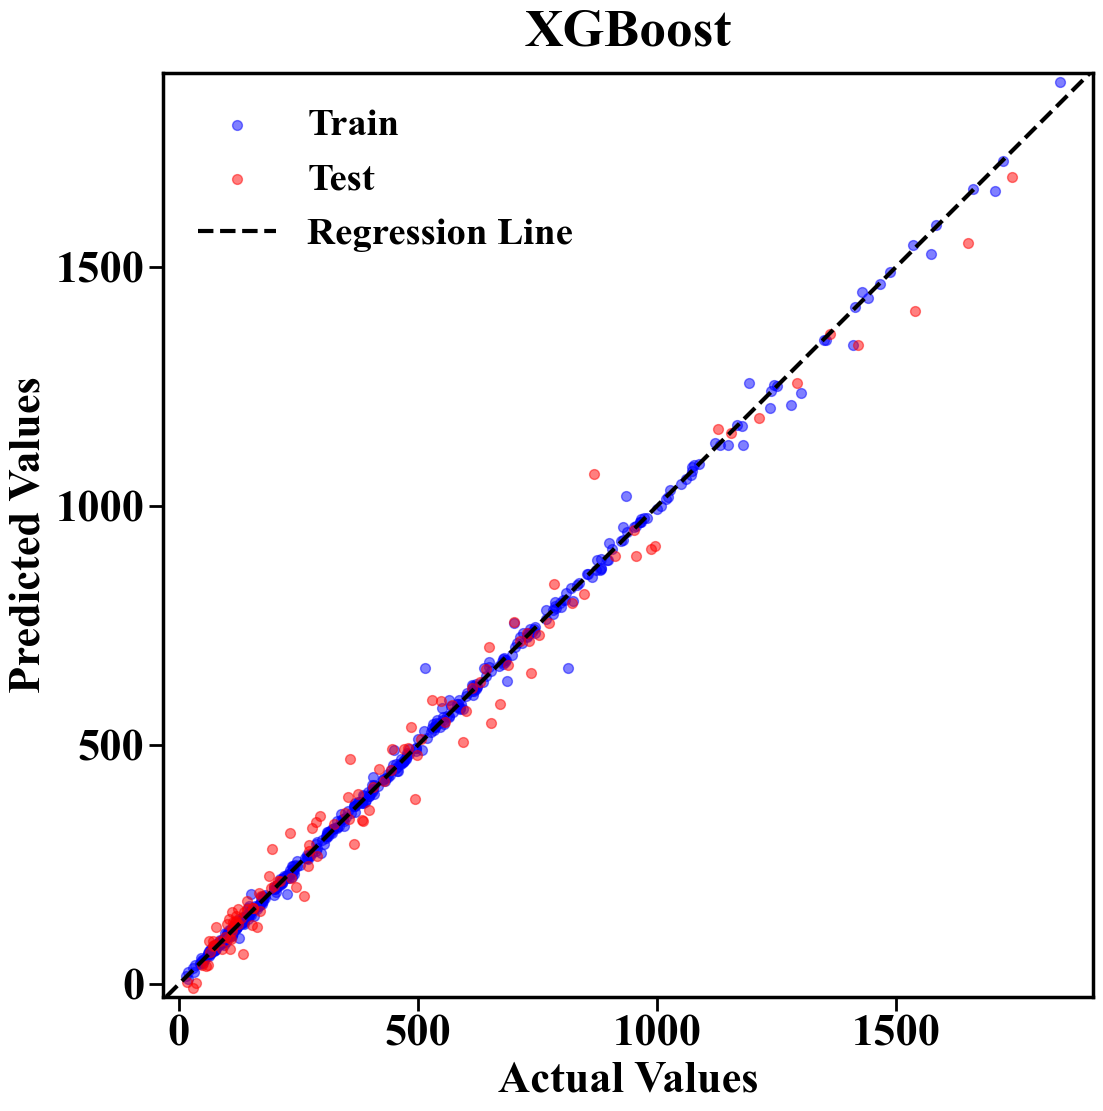

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.998,7.23,2.52,15.6,0.985,33.04,13.7,46.48


In [5]:
# 使用最佳参数训练模型
xgb_params = {
    'n_estimators': 300,
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'gamma': trial.params['gamma'],
    'max_depth': trial.params['max_depth'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_alpha': trial.params['reg_alpha'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'colsample_bylevel': trial.params['colsample_bylevel'],
    'colsample_bynode': trial.params['colsample_bynode'],    
}
model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost', figpath='xgb_actual_vs_predicted.png')
xgb_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost')
xgb_metrics

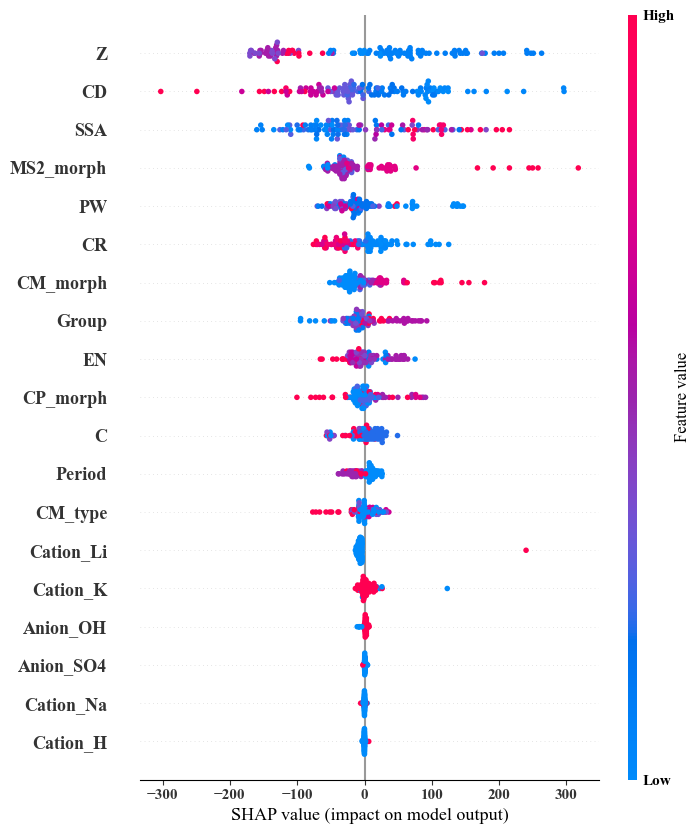

In [7]:
# 计算 SHAP 值
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# 绘制特征重要性图
shap.summary_plot(shap_values, X_test)